In [5]:
import os
import numpy as np
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

from src.datagen import DataGenerator
from src.utils import get_ytrue_ypred_targets, save_confusion_matrix, save_summary_plots

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, Dense, Dropout, \
                                    Activation, MaxPooling2D, Flatten, \
                                    BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam


def build_model():
    model = Sequential()
    model.add(Conv2D(32, (9, 9), 
                    input_shape = (128, 640, 1), 
                    padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))

    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units = 2, activation = 'softmax'))

    opt = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

def get_cb_list(name):
    earlystop_callback = EarlyStopping(monitor='val_loss', mode='min', 
                                       patience=6, min_delta=0.005, verbose=0,   
                                       restore_best_weights=True)
    
    checkpoint_callback = ModelCheckpoint(f'./models/{name}_weights_best_val_loss.h5', 
                                          monitor='val_loss', mode='min',
                                          save_best_only=True, verbose=0)

    reducelr_callback = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.8, 
                                          patience=2, min_delta=0.005, verbose=1)

    callbacks_list = [checkpoint_callback, reducelr_callback, earlystop_callback]

    return callbacks_list


def get_datagens(include=['Rock', 'Hip-Hop'], 
                 splits=['training', 'validation', 'test'], 
                 bs=[64,16,1]):
    datagens = []
    test = False

    for split, bs in zip(splits, bs):
        if 'test' in split:
            test = True

        datagen = DataGenerator('./data/'+split, include=include, 
                                batch_size=bs, dim=(128,640), 
                                n_channels=1, test=test)

        datagens.append(datagen)
    
    return tuple(datagens)


# def main(name='model3'):
#     # Build model
#     model = build_model()

#     # Get callbacks
#     cbs = get_cb_list()
    
#     # Get datagens
#     train_dg, valid_dg, test_dg = get_datagens(include=['Rock', 'Hip-Hop'], 
#                                                splits=['training', 'validation', 'test'], 
#                                                bs=[64,16,1])

#     # Train
#     history = model.fit_generator(generator=train_dg, epochs=100,
#                                   validation_data=valid_dg, verbose=1, 
#                                   callbacks=cbs)

#     # Save
#     model.save(f'./models/{name}_arch_and_weights.h5')
#     save_summary_plots(history, fpath=f'./images/{name}_summary.png')
#     y_true, y_pred, target_names = get_true_pred_targets(model, test_dg)
#     save_confusion_matrix(y_true, y_pred, target_names, fpath=f'./images/{name}_cm.png')
    
# if __name__ == "__main__":
#     main()

In [6]:
name='model3'

# Build model
model = build_model()

# Get callbacks
cbs = get_cb_list(name)

# Get datagens
train_dg, valid_dg, test_dg = get_datagens(include=['Rock', 'Hip-Hop'], 
                                           splits=['training', 'validation', 'test'], 
                                           bs=[64,16,1])

# Train
history = model.fit_generator(generator=train_dg, epochs=5,
                              validation_data=valid_dg, verbose=1, 
                              callbacks=cbs)

W1108 20:35:45.122883 140541076174656 deprecation.py:323] From /opt/conda/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
24/24 [==============================] - 24s 999ms/step - loss: 0.6922 - accuracy: 0.5085 - val_loss: 0.6895 - val_accuracy: 0.5104
Epoch 2/10
24/24 [==============================] - 15s 613ms/step - loss: 0.6834 - accuracy: 0.5404 - val_loss: 0.6832 - val_accuracy: 0.7396
Epoch 3/10
24/24 [==============================] - 15s 611ms/step - loss: 0.6630 - accuracy: 0.6152 - val_loss: 0.7091 - val_accuracy: 0.5104
Epoch 4/10
23/24 [===========================>..] - ETA: 0s - loss: 0.7018 - accuracy: 0.5061
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
24/24 [==============================] - 15s 612ms/step - loss: 0.7009 - accuracy: 0.5117 - val_loss: 0.6914 - val_accuracy: 0.5104
Epoch 5/10
24/24 [==============================] - 15s 613ms/step - loss: 0.6888 - accuracy: 0.5417 - val_loss: 0.6878 - val_accuracy: 0.5104
Epoch 6/10
23/24 [===========================>..] - ETA: 0s - loss: 0.6842 - accuracy: 0.5666
Epoch 00006: ReduceLROnPlatea

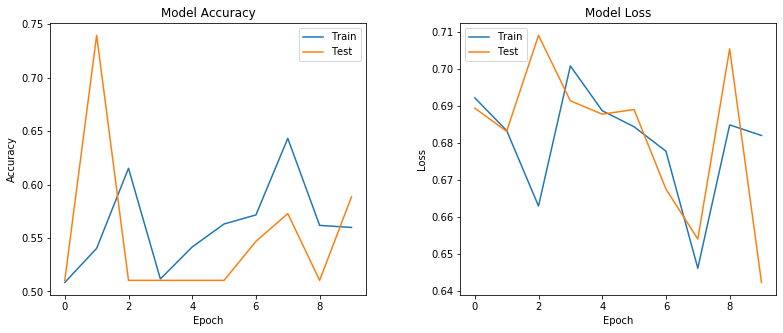

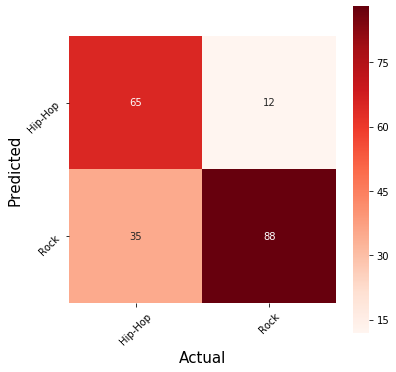

In [8]:
# Save
model.save(f'./models/{name}_arch_and_weights.h5')
save_summary_plots(history, fpath=f'./images/{name}_summary.png')
y_true, y_pred, target_names = get_ytrue_ypred_targets(model, test_dg)
save_confusion_matrix(y_true, y_pred, target_names, fpath=f'./images/{name}_cm.png')